In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image

In [2]:
# Komentar: Menyiapkan data path dan parameter dasar
train_dir = './dataset_model2/train'  # Path ke folder dataset training
val_dir = './dataset_model2/val'      # Path ke folder dataset validasi

In [ ]:
# ImageDataGenerator untuk augmentasi gambar
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Rescale nilai pixel gambar antara 0 dan 1
    shear_range=0.2,       # Melakukan shear transformasi
    zoom_range=0.2,        # Zoom in gambar
    horizontal_flip=True,   # Membalik gambar secara horizontal
    rotation_range=20,      # Memutar gambar hingga 20 derajat
    width_shift_range=0.2,  # Menggeser gambar secara horizontal
    height_shift_range=0.2, # Menggeser gambar secara vertikal
    brightness_range=[0.8, 1.2]  # Mengatur kecerahan gambar
)


In [4]:
val_datagen = ImageDataGenerator(rescale=1./255)  # Hanya rescale tanpa augmentasi

# Menghasilkan data dari direktori dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Ukuran gambar yang diinginkan
    batch_size=32,           # Ukuran batch
    class_mode='categorical' # Menggunakan class_mode categorical untuk multi-label classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 2100 images belonging to 6 classes.
Found 528 images belonging to 6 classes.


In [5]:
# Membangun model CNN
model = Sequential()

# Layer convolutional pertama
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer convolutional kedua
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer convolutional ketiga
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layer pertama
model.add(Dense(512, activation='relu'))

# Dropout untuk mengurangi overfitting
model.add(Dropout(0.5))

# Output layer dengan jumlah kelas sesuai dengan jumlah label
model.add(Dense(6, activation='softmax'))  # Menggunakan 6 kelas untuk 6 penyakit

# Compiling model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [6]:
# Callback EarlyStopping untuk menghentikan training saat val_accuracy >= 90%
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True, verbose=1)

# Definisikan threshold akurasi
class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy >= self.threshold:
            print(f"\nAkurasi validasi telah mencapai {self.threshold * 100:.2f}%, menghentikan training.")
            self.model.stop_training = True

threshold_callback = ThresholdCallback(threshold=0.95)

In [ ]:
def tambah_label_dataset(model, new_data_dir, target_size=(150, 150), batch_size=32):
    """
    Fungsi untuk menambahkan label baru pada dataset.
    :param model: Model yang sudah dilatih sebelumnya.
    :param new_data_dir: Path ke dataset baru yang ingin ditambahkan.
    :param target_size: Ukuran gambar yang diinginkan.
    :param batch_size: Ukuran batch.
    """
    # Augmentasi gambar baru
    new_data_gen = ImageDataGenerator(rescale=1./255)
    
    # Generator untuk dataset baru
    new_data_generator = new_data_gen.flow_from_directory(
        new_data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Retrain model dengan dataset baru
    model.fit(
        new_data_generator,
        steps_per_epoch=new_data_generator.samples // batch_size,
        epochs=10,
        verbose=1
    )

    print(f"Model berhasil diupdate dengan data baru dari {new_data_dir}.")
    return model

In [7]:
# Melatih model dengan early stopping
history = model.fit(
    train_generator,
    epochs=50,  # Set jumlah epoch yang cukup besar
    validation_data=val_generator,
    callbacks=[early_stopping, threshold_callback]
)


Epoch 1/50
66/66 [==============================] - 51s 764ms/step - loss: 1.7140 - accuracy: 0.2976 - val_loss: 1.1766 - val_accuracy: 0.5511
Epoch 2/50
66/66 [==============================] - 35s 530ms/step - loss: 1.1801 - accuracy: 0.5552 - val_loss: 1.0635 - val_accuracy: 0.5890
Epoch 3/50
66/66 [==============================] - 34s 521ms/step - loss: 0.9559 - accuracy: 0.6371 - val_loss: 0.6528 - val_accuracy: 0.7576
Epoch 4/50
66/66 [==============================] - 34s 521ms/step - loss: 0.8119 - accuracy: 0.6952 - val_loss: 0.6358 - val_accuracy: 0.7633
Epoch 5/50
66/66 [==============================] - 34s 522ms/step - loss: 0.7861 - accuracy: 0.7210 - val_loss: 0.5554 - val_accuracy: 0.7973
Epoch 6/50
66/66 [==============================] - 35s 528ms/step - loss: 0.7021 - accuracy: 0.7433 - val_loss: 0.6507 - val_accuracy: 0.7841
Epoch 7/50
66/66 [==============================] - 35s 523ms/step - loss: 0.6105 - accuracy: 0.7757 - val_loss: 0.5836 - val_accuracy: 0.7652

In [ ]:
# Simpan model
model.save('model/model_penyakit_daun_padi.keras')

In [10]:
# Evaluasi model pada data validasi
val_loss, val_acc = model.evaluate(val_generator)
print(f"Akurasi Validasi: {val_acc * 100:.2f}%")

17/17 [==============================] - 4s 211ms/step - loss: 0.2360 - accuracy: 0.9223
Akurasi Validasi: 92.23%


In [12]:
def convert_to_tflite(model, saved_model_path='model_penyakit_daun_padi.keras', tflite_model_path='model_penyakit_daun_padi.tflite'):
    # Simpan model yang sudah dilatih
    model.save(saved_model_path)

    # Memuat model yang disimpan dan mengonversinya ke format TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Simpan model TFLite ke file
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    print(f"Model berhasil dikonversi dan disimpan sebagai {tflite_model_path}.")

# Mengonversi model ke TFLite
convert_to_tflite(model)

INFO:tensorflow:Assets written to: C:\Users\alhib\AppData\Local\Temp\tmpdwtio0_1\assets


INFO:tensorflow:Assets written to: C:\Users\alhib\AppData\Local\Temp\tmpdwtio0_1\assets


Model berhasil dikonversi dan disimpan sebagai model_penyakit_daun_padi.tflite.


In [2]:
def test_model_image_tflite(model, img_path, target_size=(150, 150)):
    """
    Fungsi untuk menguji model TensorFlow Lite pada gambar yang diberikan dan menampilkan probabilitas label.
    
    :param model: Model TensorFlow Lite yang sudah dikonversi
    :param img_path: Path ke gambar yang akan diuji
    :param target_size: Ukuran target gambar yang digunakan untuk model
    :return: Probabilitas prediksi tiap label
    """
    # Memuat gambar dan mengubah ukurannya
    img = image.load_img(img_path, target_size=target_size)
    
    # Mengonversi gambar menjadi array numpy dan menormalisasi (rescale)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch

    # Menggunakan model TFLite untuk prediksi
    interpreter = tf.lite.Interpreter(model_path="model_penyakit_daun_padi.tflite")
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    # Ambil hasil prediksi
    predictions = interpreter.get_tensor(output_details[0]['index'])

    # Menampilkan probabilitas setiap label
    class_names = list(val_generator.class_indices.keys())  # Nama kelas berdasarkan generator
    prob_dict = {class_names[i]: predictions[0][i] for i in range(len(class_names))}
    
    print("Probabilitas Prediksi untuk Gambar:")
    for label, prob in prob_dict.items():
        print(f"{label}: {prob * 100:.2f}%")
    
    # Menampilkan gambar yang diuji
    plt.imshow(img)
    plt.axis('off')  # Matikan sumbu
    plt.title(f"Prediksi: {class_names[np.argmax(predictions)]}, Probabilitas: {max(prob_dict.values()) * 100:.2f}%")
    plt.show()
    
    return prob_dict

# Contoh penggunaan
img_path = 'test/gandum.jpg'  # Ganti dengan path gambar yang ingin diuji
probabilities = test_model_image_tflite(model, img_path)

# Evaluasi model pada data validasi
val_loss, val_acc = model.evaluate(val_generator)
print(f"Akurasi Validasi: {val_acc * 100:.2f}%")

# Menggunakan model untuk prediksi pada data validasi
val_predictions = model.predict(val_generator, verbose=1)

# Mengubah prediksi menjadi label yang sesuai (argmax untuk kategori dengan probabilitas tertinggi)
predicted_labels = np.argmax(val_predictions, axis=1)

# Mendapatkan label sebenarnya
true_labels = val_generator.classes

# Menampilkan classification report (precision, recall, f1-score)
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=val_generator.class_indices.keys()))

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Grafik Akurasi selama pelatihan
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Grafik Kerugian (Loss) selama pelatihan
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Kerugian (Loss) Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'model' is not defined

Probabilitas kelas yang terdeteksi:
[[4.4243453e-08 7.6394565e-05 4.1009216e-08 6.2289105e-06 2.1256540e-06
  9.9991512e-01]]


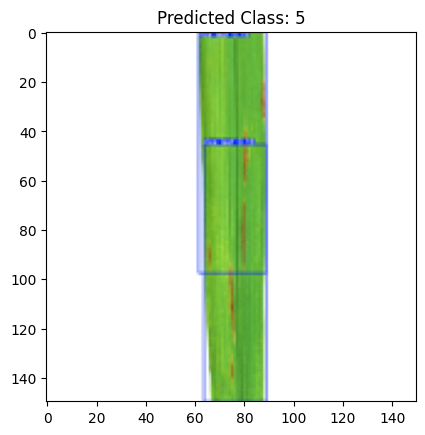

In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Fungsi untuk memuat dan menguji model TFLite
def test_tflite_model(model_path, image_path):
    # Memuat model TFLite
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Mendapatkan informasi tensor input dan output
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Menentukan ukuran input yang diharapkan oleh model
    input_shape = input_details[0]['shape']
    input_size = tuple(input_shape[1:3])  # Mengambil dimensi tinggi dan lebar
    
    # Memuat dan memproses gambar
    image = Image.open(image_path)
    image = image.resize(input_size)
    image = np.array(image, dtype=np.float32)
    
    # Jika gambar RGB, normalisasi dan ubah bentuknya
    if image.shape[-1] == 3:
        image = image / 255.0  # Normalisasi ke rentang [0, 1]
    image = np.expand_dims(image, axis=0)  # Menambah dimensi batch
    
    # Memasukkan gambar ke dalam input tensor
    interpreter.set_tensor(input_details[0]['index'], image)
    
    # Menjalankan inferensi
    interpreter.invoke()
    
    # Mendapatkan hasil dari output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # Menampilkan hasil probabilitas
    print("Probabilitas kelas yang terdeteksi:")
    print(output_data)
    
    # Jika ingin menampilkan gambar dan label prediksi
    plt.imshow(image[0])
    plt.title(f'Predicted Class: {np.argmax(output_data)}')
    plt.show()

# Contoh penggunaan
model_path = 'model/model_penyakit_daun_padi.tflite'  # Path ke file .tflite Anda
image_path = 'test/rice_leaf (173).jpg'  # Path ke gambar yang ingin diuji
test_tflite_model(model_path, image_path)
